In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import scipy.ndimage as ndimage
import matplotlib.patches as patches
import cv2
import numpy as np
import pandas as pd
import os,gc
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
torch.cuda.set_device(5)
print (torch.cuda.current_device())
#os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4,5,6,7"

5


In [2]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             #transforms.RandomCrop(crop_size),
                                             #transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
    img = transform_sequence(img).numpy() #tensor to numpy
    return img
img_path = '/data/fjsdata/NIH-CXR/images/images/' 
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', \
               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
#preparing the trainset and  testset
trN, trI, trY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/train.txt', "r") as file_descriptor: #tarinset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            trN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            trY.append(np.array(image_label))
            img = Image_Processing(os.path.join(img_path, image_name))
            trI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(trN),78468))
        sys.stdout.flush()
trI = np.array(trI)
trY = np.array(trY)   
print('The length of trainset is %d'%len(trN))
        
valN, valI, valY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/val.txt', "r") as file_descriptor: #valset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            valN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            valY.append(np.array(image_label))
            img = Image_Processing(os.path.join(img_path, image_name))
            valI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(valN),11219))
        sys.stdout.flush()
valI = np.array(valI)
valY = np.array(valY) 
print('The length of validset is %d'%len(valN))

teN, teI, teY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            teN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            teY.append(np.array(image_label))
            img = Image_Processing(os.path.join(img_path, image_name))                    
            teI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(teN),22433))
        sys.stdout.flush()
teI = np.array(teI)
teY = np.array(teY)    
print('The length of testset is %d'%len(teN))

#preparing bounding box dataset
boxdata = pd.read_csv("/data/fjsdata/NIH-CXR/chexnet_dataset/fjs_BBox.csv" , sep=',')
boxdata = boxdata[['Image Index','Finding Label','Bbox [x', 'y', 'w', 'h]']]
#print('Dataset statistic, records: %d, fields: %d' % (boxdata.shape[0], boxdata.shape[1]))
#print(boxdata.columns.values.tolist())
bbN, bbI, bbY, bBox = [],[],[],[]
for _, row in boxdata.iterrows():
    bbN.append(row['Image Index'])
    
    img = Image_Processing(os.path.join(img_path, row['Image Index']))
    bbI.append(img)
    
    labels = np.zeros(len(CLASS_NAMES))
    labels[CLASS_NAMES.index(row['Finding Label'])] = 1
    bbY.append(labels)
    
    bBox.append(np.array([row['Bbox [x'], row['y'], row['w'], row['h]']])) #xywh  
print('The length of boxset is %d'%len(bbN))
bbI = np.array(bbI)
bbY = np.array(bbY)
bBox = np.array(bBox)

78468 / 78468 The length of trainset is 78468
11219 / 11219 The length of validset is 11219
22433 / 22433 The length of testset is 22433
The length of boxset is 984


In [7]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet121, self).__init__()
        self.dense_net_121 = torchvision.models.densenet121(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_121.classifier.in_features
        self.dense_net_121.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_121(x)
        return x


class DenseNet169(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet169, self).__init__()
        self.dense_net_169 = torchvision.models.densenet169(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_169.classifier.in_features
        self.dense_net_169.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_169(x)
        return x


class DenseNet201(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet201, self).__init__()
        self.dense_net_201 = torchvision.models.densenet201(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_201.classifier.in_features
        self.dense_net_201.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_201(x)
        return x

def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [9]:
#model training
N_CLASSES = len(CLASS_NAMES) #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
AUROC_best = 0.
batchSize = 32 #'Batch Size': 32
for epoch in range(50):#'Max Epoch': 50
    model.train()  # set network as train mode
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    num_batches = len(shuffled_idx) // batchSize + 1
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(shuffled_idx), (i+1)*batchSize])
            selected_idx = shuffled_idx[min_idx:max_idx]
            I_batch = torch.from_numpy(trI[selected_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[selected_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch)#permute the dims of matrix， .permute(0, 3, 1, 2)
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch)#forword， .permute(0, 3, 1, 2)
            curr_loss = criterion(y_outputs, y_batch)
            gt = torch.cat((gt, y_batch), 0)
            pred = torch.cat((pred, y_outputs.data), 0)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    AUROCs = compute_AUCs(gt, pred)
    AUROC_avg = np.array(AUROCs).mean()
    print("\r Eopch: %5d val_loss = %.6f avg_auroc= %.6f" % (epoch + 1, np.mean(loss_val), AUROC_avg))
    #if np.mean(loss_val) < best_loss:
    if AUROC_avg > AUROC_best:
        best_loss = np.mean(loss_val)
        AUROC_best = AUROC_avg
        best_net = copy.deepcopy(model)        
print("\r best_loss = %.6f best_auroc = %0.6f" % (best_loss, AUROC_best))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

 351 / 351 : validation loss = 0.149337Eopch:     1 val_loss = 0.168244 avg_auroc= 0.744863
 351 / 351 : validation loss = 0.170648Eopch:     2 val_loss = 0.159567 avg_auroc= 0.777587
 351 / 351 : validation loss = 0.122269Eopch:     3 val_loss = 0.158472 avg_auroc= 0.777996
 351 / 351 : validation loss = 0.111553Eopch:     4 val_loss = 0.156806 avg_auroc= 0.784833
 351 / 351 : validation loss = 0.143582Eopch:     5 val_loss = 0.158639 avg_auroc= 0.794487
 351 / 351 : validation loss = 0.119506Eopch:     6 val_loss = 0.155760 avg_auroc= 0.791504
 351 / 351 : validation loss = 0.133075Eopch:     7 val_loss = 0.152787 avg_auroc= 0.800098
 351 / 351 : validation loss = 0.128428Eopch:     8 val_loss = 0.153791 avg_auroc= 0.804130
 351 / 351 : validation loss = 0.150763Eopch:     9 val_loss = 0.154595 avg_auroc= 0.797389
 351 / 351 : validation loss = 0.116267Eopch:    10 val_loss = 0.154232 avg_auroc= 0.798973
 351 / 351 : validation loss = 0.138224Eopch:    11 val_loss = 0.151752 avg_auro

In [10]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 701 / 702 The average AUROC is 0.8105
The AUROC of Atelectasis is 0.7919
The AUROC of Cardiomegaly is 0.9038
The AUROC of Effusion is 0.8744
The AUROC of Infiltration is 0.6942
The AUROC of Mass is 0.8142
The AUROC of Nodule is 0.7286
The AUROC of Pneumonia is 0.7477
The AUROC of Pneumothorax is 0.8431
The AUROC of Consolidation is 0.7933
The AUROC of Edema is 0.8777
The AUROC of Emphysema is 0.8726
The AUROC of Fibrosis is 0.7986
The AUROC of Pleural_Thickening is 0.7528
The AUROC of Hernia is 0.8545


In [11]:
#performance of box
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(bbY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(bbY), (i+1)*batchSize])
        I_batch = torch.from_numpy(np.array(bbI)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(bbY)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in [0, 1, 2, 3, 4, 5, 6, 7]:
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 30 / 31 The average AUROC is 0.7735
The AUROC of Atelectasis is 0.7152
The AUROC of Cardiomegaly is 0.9294
The AUROC of Effusion is 0.7977
The AUROC of Infiltration is 0.6653
The AUROC of Mass is 0.7746
The AUROC of Nodule is 0.7567
The AUROC of Pneumonia is 0.6669
The AUROC of Pneumothorax is 0.8823


(-0.5, 223.5, 223.5, -0.5)

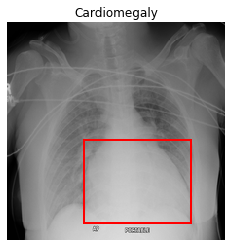

In [18]:
bidx = 167
raw_img = Image.open(os.path.join(img_path, bbN[bidx])).convert('RGB')
width, height = raw_img.size   # Get dimensions
x_scale = 256/width
y_scale = 256/height
raw_img = raw_img.resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
crop_del = (256-224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
raw_img= np.array(raw_img)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(raw_img)
x, y, w, h = int(bBox[bidx][0])*x_scale-crop_del, int(bBox[bidx][1])*y_scale-crop_del, int(bBox[bidx][2])*x_scale, int(bBox[bidx][3])*y_scale
rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes

img_label = np.array(CLASS_NAMES)[np.where(bbY[bidx]==1)[0]]
plt.title(img_label[0]) #show labels
plt.axis('off')

0.1524 -> Cardiomegaly
0.0792 -> Infiltration
0.0723 -> Effusion
0.0655 -> Edema
0.0639 -> Atelectasis
0.0635 -> Consolidation
0.0634 -> Pneumonia
0.0631 -> Nodule
0.0629 -> Pleural_Thickening
0.0628 -> Pneumothorax
0.0628 -> Fibrosis
0.0627 -> Emphysema
0.0627 -> Mass
0.0626 -> Hernia


(-0.5, 223.5, 223.5, -0.5)

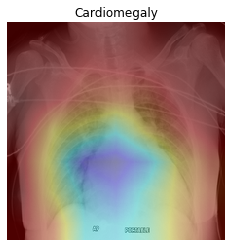

In [19]:
network_model = best_net.dense_net_121.features
network_model.eval()  # set network as evaluation model
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[bidx]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    var_output = network_model(input_img)#forword
    logit = best_net(input_img)#forword
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
        
cls_weights = list(best_net.parameters())
weight_softmax = np.squeeze(cls_weights[-2].data.cpu().numpy()) 
classes = {0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Effusion', 3: 'Infiltration', 4:'Mass', 5:'Nodule', 6:'Pneumonia',\
           7:'Pneumothorax',8:'Consolidation',9:'Edema',10:'Emphysema',11:'Fibrosis',12:'Pleural_Thickening',13:'Hernia'}
# output: the prediction
for i in range(0, N_CLASSES):
    line = '{:.4f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
    
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape

    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
    #cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size_upsample)
    return cam_img
#get the class activation maps
cam_img = returnCAM(var_output.cpu().data.numpy(), weight_softmax, idx[0].item())
heat_map = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

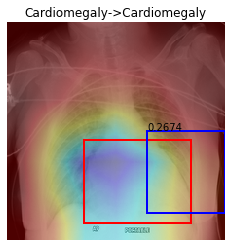

In [20]:
def IOU(xywh1, xywh2):#metric
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return (intersection / union)

# Find local maxima
data = cam_img
neighborhood_size = 100
threshold = .1

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
#for _ in range(5):
#    maxima = binary_dilation(maxima) 
labeled, num_objects = ndimage.label(maxima)
#slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(output_img)
rect = patches.Rectangle((x, y), w, h,linewidth=2, edgecolor='r', facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        x_p = int(max(pt[0], 0.))
        y_p = int(max(pt[1], 0.))
        w_p = int(min(x_p + w, 224)) - x_p
        h_p = int(min(y_p + h, 224)) - y_p
        
        IoU_score = IOU([x,y,w,h],[x_p,y_p,w_p,h_p])
        #print('IoU_score = {:.4f}'.format(IoU_score))
        rect = patches.Rectangle((x_p, y_p), w_p, h_p,linewidth=2, edgecolor='b', facecolor='none')# Create a Rectangle patch
        ax.add_patch(rect)# Add the patch to the Axes
        ax.text(x_p, y_p, '{:.4f}'.format(IoU_score))

plt.title(img_label[0] + '->' + classes[idx[0].item()]) #show labels
plt.axis('off')